In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
) 

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(data["label"].unique()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",               
    evaluation_strategy="epoch",         
    save_strategy="epoch",               
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=16,        
    num_train_epochs=3,                   
    weight_decay=0.01,                    
    logging_dir="./logs",                 
    logging_steps=10,                     
    save_steps=500,                       
    load_best_model_at_end=True,          
    metric_for_best_model="accuracy",     
    save_total_limit=1,                   
)

def compute_metrics(pred):
    logits, labels = pred
    logits = torch.tensor(logits).to(device)  
    labels = torch.tensor(labels).to(device)  
    predictions = torch.argmax(logits, axis=-1)
    acc = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())  # Convert tensors to numpy arrays on CPU
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu().numpy(), predictions.cpu().numpy(), average="weighted")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print("Evaluation Results:", results)

def compute_accuracy_on_test():
    test_preds = trainer.predict(test_dataset)
    logits = test_preds.predictions
    # Convert logits to a PyTorch tensor
    logits_tensor = torch.tensor(logits)
    # Use torch.argmax on the tensor
    predictions = torch.argmax(logits_tensor, axis=-1)
    acc = accuracy_score(test_labels.to_numpy(), predictions.cpu().numpy())
    print(f"Accuracy on the Test Set: {acc * 100:.2f}%")

compute_accuracy_on_test()


Map:   0%|          | 0/260505 [00:00<?, ? examples/s]

Map:   0%|          | 0/156304 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Shezan\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Shezan\AppData\Local\Temp\ipykernel_22540\2786223544.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `Traini

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.048600,0.106517,0.936969,0.935296,0.942551,0.936969
2,0.174400,0.095451,0.939099,0.940328,0.950060,0.939099
3,0.062300,0.093027,0.940859,0.941550,0.946737,0.940859


Evaluation Results: {'eval_loss': 0.09302742779254913, 'eval_accuracy': 0.9408588391851777, 'eval_f1': 0.9415499523968243, 'eval_precision': 0.9467365242346572, 'eval_recall': 0.9408588391851777, 'eval_runtime': 156.4338, 'eval_samples_per_second': 999.17, 'eval_steps_per_second': 62.448, 'epoch': 3.0}
Accuracy on the Test Set: 94.09%


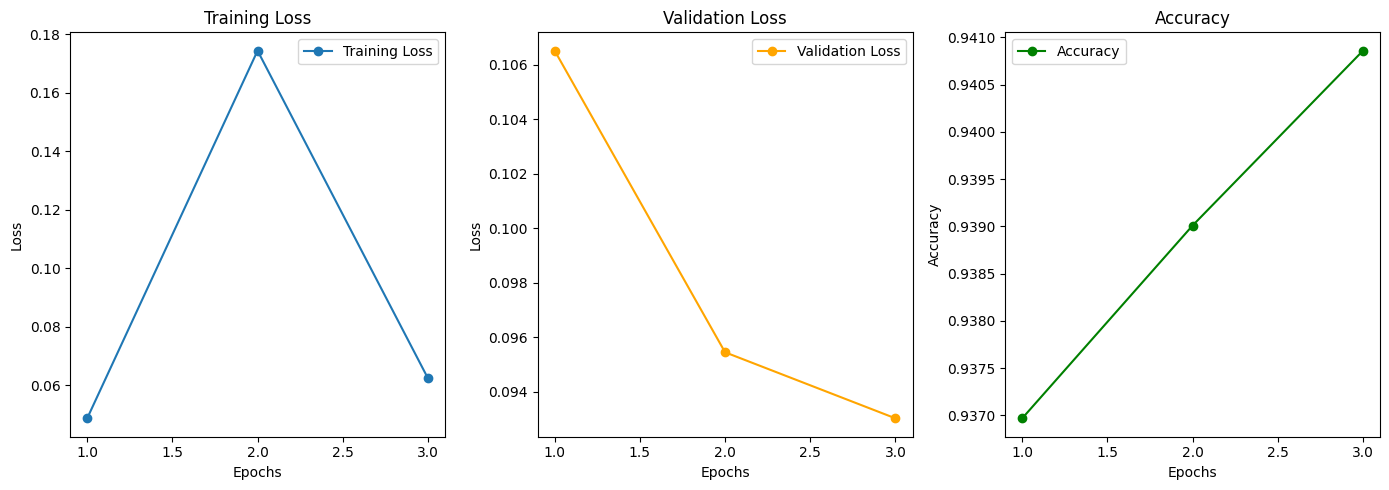

In [6]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
training_loss = [0.048600, 0.174400, 0.062300]
validation_loss = [0.106517, 0.095451, 0.093027]
accuracy = [0.936969, 0.939009, 0.940859]

# Plotting Training Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting Validation Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
